# Analyze Dark Scan
Derivation of Dark Signal Correction

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%matplotlib inline

from astropy.io import ascii    
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from lasp import *

## Read dark counts, convert to counts/sec

In [35]:
datasetName = 'Dark'
d = readDatasetByName( datasetName)

In [36]:
countRate = d['instrumentTelemetry']['counts'] / d['integrationTime']['intTime (ms)']

<function matplotlib.pyplot.show>

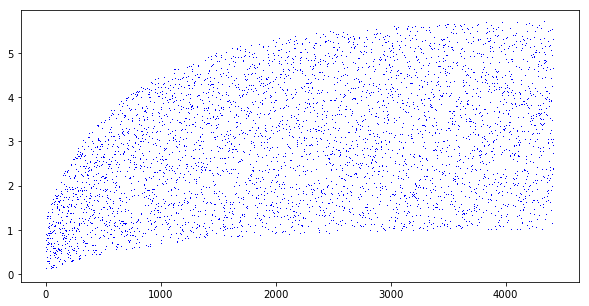

In [37]:
plt.figure(figsize=(10,5))
plt.plot(countRate, 'b,')
plt.show

Interesting!  So the dark current varies.  Presumably with detector temperature.  Let's explore more about this.

## Dark current correlation with temperature.

First question is whether we need to interpolate the arrays.

### Dark current vs. time

4415


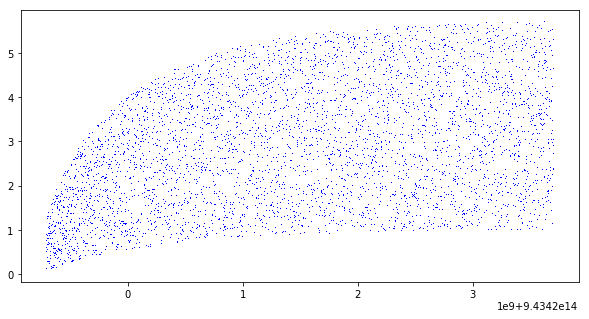

In [38]:
plt.figure(figsize=(10,5))
time1 = d['instrumentTelemetry']['microsecondsSinceGpsEpoch']
plt.plot(time1,countRate,'b,')
plt.show
print len(time1)

### Temperature vs. time

4414


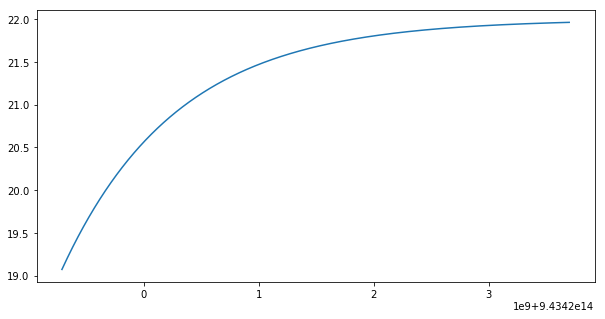

In [39]:
plt.figure(figsize=(10,5))
time2 = d['detectorTemp']['microsecondsSinceGpsEpoch']
value2 = d['detectorTemp']['temp (C)']
plt.plot(time2,value2)
plt.show
print len(time2)

# Resample temp to match dark current

In [40]:
temp = np.interp(time1, time2, value2)

<function matplotlib.pyplot.show>

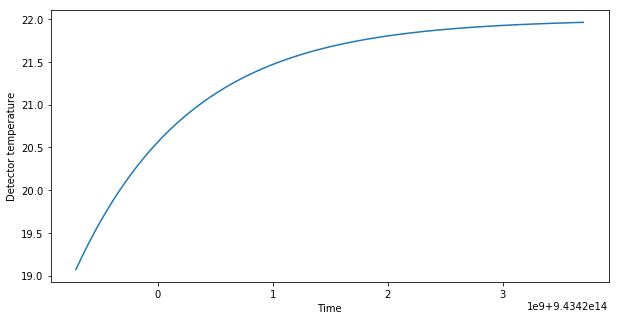

In [41]:
plt.figure(figsize=(10,5))
plt.plot(time1,temp)
plt.xlabel('Time')
plt.ylabel('Detector temperature')
plt.show

## Compare dark current to temp

<function matplotlib.pyplot.show>

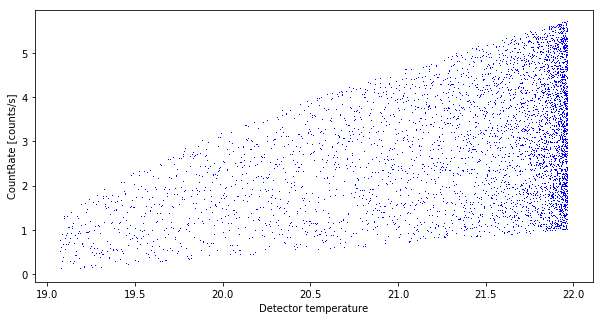

In [42]:
plt.figure(figsize=(10,5))
plt.plot(temp,countRate,'b,')
plt.ylabel('CountRate [counts/s]')
plt.xlabel('Detector temperature')
plt.show

## Fit line to dark current vs. temp

In [43]:
# get the fit parameters...
z = np.polyfit(temp, countRate, 3)

# define a function to implement the parameters...
p = np.poly1d(z)

In [49]:
# define an array of temperatures to span the full range...
tMin = np.min(temp)
tMax = np.max(temp)
temp2 = np.linspace( tMin, tMax)

# obtain predicted countrates for these temperatures based 
# on the "p" function defined above to implement the parameters.
yfit = p(temp2)

<function matplotlib.pyplot.show>

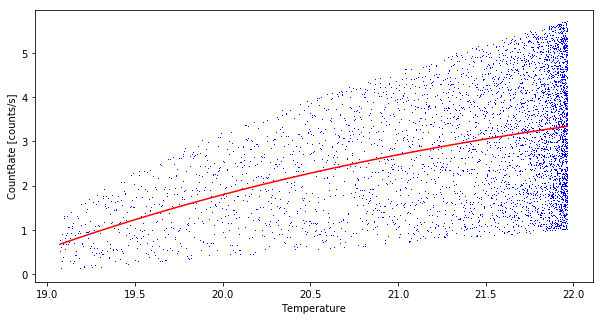

In [50]:
# Show the fit vs. the data
plt.figure(figsize=(10,5))
plt.plot(temp,countRate,'b,', temp2,yfit,'r-')
plt.xlabel('Temperature')
plt.ylabel('CountRate [counts/s]')
plt.show

## Define a function to implement dark correction

In [51]:
def applyDarkCorrection( countRate, detectorTemp):
    '''
    Given arrays of signal (countRate, units=counts/sec) and detector temperature (detectorTemp),
    subtract the estimate dark current and return corrected signal.
    '''
    
    z = np.array([1.34849318e-02, -9.67799807e-01, 2.35761388e+01, -1.90484234e+02])
    p = np.poly1d(z)
    darkCurrent = p(detectorTemp)
    correctedCountRate = countRate - darkCurrent
    return correctedCountRate

## Confirm that this subtracts the dark current properly

In [52]:
correctedCountRate = applyDarkCorrection( countRate, temp)

<function matplotlib.pyplot.show>

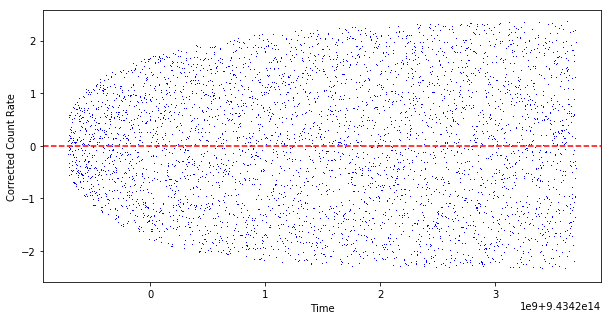

In [53]:
plt.figure(figsize=(10,5))
plt.plot(time1,correctedCountRate,'b,')
plt.axhline(y=0, color='r', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Corrected Count Rate')
plt.show

Given that the data are symmetrically arrayed around a corrected count rate of zero, the correction appears to have been applied correctly.

## Conclusion
* Dark current appears to vary with temperature
* The specific variation is not well described by a linear relation between dark current and temp, but is well dedescribed by a 2nd order polynomial
* A routine to apply a correction for dark current appears to function correctly.